# PtyPy QC & Ingestion — **Scan-Space Masking + Reconstruction Demo**

This extends the previous demo with **scan-space masking** (rectangle or circle in stage coordinates) and shows two downstream options:

1. **Subset export**: re‑ingest/export only frames inside the mask into a new standardized HDF5.
2. **PtyPy mask JSON**: emit a JSON file of accepted frame indices for PtyPy's ingest layer to exclude frames outside the mask.

It also composes a **PtyPy reconstruction** command for either the subset HDF5 **or** the JSON‑masked original HDF5, and can run it directly from the notebook.


## Prereqs & paths

- Local clone of `beamline_ptypy_Ingest` (or set `PTYPY_INGEST_REPO`).
- CLIs importable (e.g., `python -m beamline_ptypy_ingest.ingest_hdf5 --help`).
- An evaluator or existing QC outputs are **not required** for this section; we recompute STXM here for the overlay.


In [1]:
# ---- Config ----
from pathlib import Path
import os, sys, json, subprocess, shlex
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle

# Repo location and imports
REPO_ROOT = Path(os.environ.get("PTYPY_INGEST_REPO", ".")).resolve()
if (REPO_ROOT / "beamline_ptypy_ingest").exists():
    sys.path.insert(0, str(REPO_ROOT))

# Standardized input HDF5 from prior ingest step
STD_HDF5 = Path(os.environ.get("STD_HDF5", REPO_ROOT / "qc_outputs_demo" / "standardized_demo.h5")).resolve()

# Output dirs/files
OUT_DIR   = Path(os.environ.get("OUT_DIR", REPO_ROOT / "qc_outputs_demo")).resolve()
MASK_DIR  = OUT_DIR / "masking"
MASK_DIR.mkdir(parents=True, exist_ok=True)
MASK_MODE = "rect" # "circ" or "rect"

# Subset re-ingest output
SUBSET_HDF5 = MASK_DIR / "standardized_subset.h5"

# PtyPy indices JSON (accept list) for masking during reconstruction
PTYPY_JSON  = MASK_DIR / "ptypy_accept_indices.json"

print("REPO_ROOT =", REPO_ROOT)
print("STD_HDF5  =", STD_HDF5)
print("OUT_DIR   =", OUT_DIR)

REPO_ROOT = /Users/gvr/code/hermes_ptypy_ingest/beamline_ptypy_ingest
STD_HDF5  = /Users/gvr/code/hermes_ptypy_ingest/beamline_ptypy_ingest/qc_outputs_demo/standardized_demo.h5
OUT_DIR   = /Users/gvr/code/hermes_ptypy_ingest/beamline_ptypy_ingest/qc_outputs_demo


In [2]:
# ---- Load standardized data, compute STXM & positions ----
with h5py.File(STD_HDF5, "r") as h5:
    I = h5["/entry/data"][()]              # (N, ny, nx)
    # Accept either split pos_x/pos_y or combined (N,2)
    if "/entry/pos_x" in h5 and "/entry/pos_y" in h5:
        pos_x = h5["/entry/pos_x"][()].astype(float).ravel()
        pos_y = h5["/entry/pos_y"][()].astype(float).ravel()
    else:
        pos = h5["/entry/pos"][()]         # (N,2) [x,y]
        pos_x = pos[:,0].astype(float)
        pos_y = pos[:,1].astype(float)

N = I.shape[0]
stxm_vals = np.log1p(I.sum(axis=(1,2))).astype(float)  # log sum(I)

# grid for overlay
from ingest.evaluate import grid_average
stxm_img, xedges, yedges, counts = grid_average(stxm_vals, pos_x, pos_y, grid_shape=None)

print("Frames:", N)
print("pos_x range:", (pos_x.min(), pos_x.max()))
print("pos_y range:", (pos_y.min(), pos_y.max()))

Frames: 256
pos_x range: (np.float64(-5e-05), np.float64(5e-05))
pos_y range: (np.float64(-5e-05), np.float64(5e-05))


## Define a scan-space mask

Two modes are supported:

- **Rectangle**: `--rect CX CY W H` (center and size in stage units, same units as `pos_x/pos_y` in the standardized file).
- **Circle**:    `--circ CX CY R`.

Edit the parameters below to hardcode a region. The overlay is drawn on the STXM image for verification, and the selected frame indices are saved to JSON for PtyPy masking.


In [3]:
# ---- Mask parameters (edit these) ----
MASK_MODE = "rect"         # "rect" or "circ"
CX = float((pos_x.min() + pos_x.max())/2)   # center x  (meters)
CY = float((pos_y.min() + pos_y.max())/2)   # center y  (meters)

# Rectangle: width/height in meters; Circle: radius in meters
W  = (pos_x.max() - pos_x.min()) * 0.6      # rectangle width
H  = (pos_y.max() - pos_y.min()) * 0.6      # rectangle height
R  = min(W, H)/2                             # circle radius

print("Mask mode:", MASK_MODE)
print("Centre (m):", CX, CY)
print("Rect W,H (m):", W, H, "  Circle R (m):", R)

Mask mode: rect
Centre (m): 0.0 0.0
Rect W,H (m): 6e-05 6e-05   Circle R (m): 3e-05


In [4]:
# ---- Build boolean selection for each frame ----
if MASK_MODE == "rect":
    sel = (np.abs(pos_x - CX) <= W/2) & (np.abs(pos_y - CY) <= H/2)
    overlay_patch = Rectangle((CX - W/2, CY - H/2), W, H, fill=False, lw=1.5)
elif MASK_MODE == "circ":
    sel = ((pos_x - CX)**2 + (pos_y - CY)**2) <= (R**2)
    overlay_patch = Circle((CX, CY), R, fill=False, lw=1.5)
else:
    raise ValueError("MASK_MODE must be 'rect' or 'circ'")

accept_idx = np.nonzero(sel)[0].astype(int)
reject_idx = np.setdiff1d(np.arange(N), accept_idx)

print(f"Selected {accept_idx.size} / {N} frames")

# Save a PtyPy-style accept list JSON
with open(PTYPY_JSON, "w") as f:
    json.dump({"accept_indices": accept_idx.tolist()}, f, indent=2)
print("Wrote:", PTYPY_JSON)

Selected 81 / 256 frames
Wrote: /Users/gvr/code/hermes_ptypy_ingest/beamline_ptypy_ingest/qc_outputs_demo/masking/ptypy_accept_indices.json


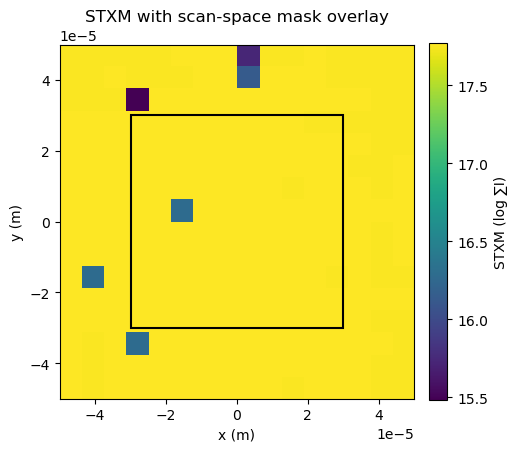

In [5]:
# ---- Visualize mask overlay on STXM ----
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(stxm_img, origin='lower',
               extent=(xedges[0], xedges[-1], yedges[0], yedges[-1]))
cb = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label("STXM (log ∑I)")

# draw patch in stage coordinates
ax.add_patch(overlay_patch)
ax.set_title("STXM with scan-space mask overlay")
ax.set_xlabel("x (m)"); ax.set_ylabel("y (m)")
plt.show()

## Option A — Re‑ingest/export a subset HDF5

Use the region flags in your ingest CLI to write a **subset** standardized file containing only frames inside the region.


In [6]:
# ---- Re-ingest with region filter (subset export) ----
# Adjust CLI module/flags to match your implementation if they differ.
cmd = [sys.executable, "-m", "beamline_ptypy_ingest.ingest_hdf5",
       "--input", str(STD_HDF5),
       "--output", str(SUBSET_HDF5),
       "--frames-per-pos", "1",
       "--grouping", "none"]

if MASK_MODE == "rect":
    cmd += ["--rect", str(CX), str(CY), str(W), str(H)]
else:
    cmd += ["--circ", str(CX), str(CY), str(R)]

print("Subset export command:")
print(" ".join(shlex.quote(c) for c in cmd))

RUN_SUBSET_EXPORT = False  # set True to execute
if RUN_SUBSET_EXPORT:
    subprocess.run(cmd, check=True)
    print("Wrote subset:", SUBSET_HDF5)

Subset export command:
/Users/gvr/miniconda3/envs/ptypy_full/bin/python -m beamline_ptypy_ingest.ingest_hdf5 --input /Users/gvr/code/hermes_ptypy_ingest/beamline_ptypy_ingest/qc_outputs_demo/standardized_demo.h5 --output /Users/gvr/code/hermes_ptypy_ingest/beamline_ptypy_ingest/qc_outputs_demo/masking/standardized_subset.h5 --frames-per-pos 1 --grouping none --rect 0.0 0.0 6e-05 6e-05


## Option B — JSON mask for PtyPy ingest

Instead of writing a smaller HDF5, pass the **accept indices** JSON to your PtyPy ingest layer so it **excludes** frames outside the region at load-time.


In [7]:
# Preview the first few accepted indices for sanity
print("First 20 accept indices:", accept_idx[:20])

First 20 accept indices: [ 68  69  70  71  72  73  74  75  76  84  85  86  87  88  89  90  91  92
 100 101]


## Launch a PtyPy reconstruction

Choose whether to reconstruct the **subset file** (Option A) or the **full file with JSON masking** (Option B).

> The example below assumes you have a runnable recipe script, e.g. `examples/ptypy_recipe_hdf5.py`, that accepts `--data` and optionally a `--ptypy-indices` JSON. Adjust the script path/flags if your repo differs.


In [ ]:
# ---- Compose a PtyPy reconstruction command ----
RECIPE = REPO_ROOT / "examples" / "ptypy_recipe_hdf5_accept.py"  # adjust if needed
ENGINE = "DM"
ITERS  = 200

USE_SUBSET = False   # True -> use subset HDF5 (Option A); False -> use JSON mask on full HDF5 (Option B)

if USE_SUBSET:
    data_path = SUBSET_HDF5
    extra = []
else:
    data_path = STD_HDF5
    # If your recipe takes a JSON accept list, provide the flag here (edit name if needed)
    extra = ["--ptypy-indices", str(PTYPY_JSON)]

recon_cmd = [sys.executable, str(RECIPE),
             "--data", str(data_path),
             "--engine", ENGINE,
             "--iters", str(ITERS)] + extra

print("Reconstruction command:")
print(" ".join(shlex.quote(c) for c in recon_cmd))

RUN_RECON = True  # set True to execute (requires your PtyPy env)
if RUN_RECON:
    subprocess.run(recon_cmd, check=True)

Reconstruction command:
/Users/gvr/miniconda3/envs/ptypy_full/bin/python /Users/gvr/code/hermes_ptypy_ingest/beamline_ptypy_ingest/examples/ptypy_recipe_hdf5_accept.py --data /Users/gvr/code/hermes_ptypy_ingest/beamline_ptypy_ingest/qc_outputs_demo/standardized_demo.h5 --engine DM --iters 200 --ptypy-indices /Users/gvr/code/hermes_ptypy_ingest/beamline_ptypy_ingest/qc_outputs_demo/masking/ptypy_accept_indices.json
